## Merge movil y fijo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, StandardScaler

Leemos los datos ya consolidados:

In [4]:
df1 = pd.read_csv('fijo_consolidado.txt', sep='\t')
df2 = pd.read_csv('base_completa_movil.csv', encoding='latin-1')

Unificamos los nombres de Columnas

In [5]:
df2 = df2[['encriptado', 'periodo', 'segmento', 'total', 'n_recl_com', 'n_recl_tec', 'n_churn', 'nota_sem']]
df1 = df1[['encriptado', 'MES', 'SEGMENTO', 'MONTO', 'RECLAMO_COM', 'RECLAMO_TEC', 'CHURN']]
df1.columns = ['encriptado', 'periodo', 'segmento', 'total', 'n_recl_com', 'n_recl_tec', 'n_churn']

Cambiamos la escala de tiempo:

In [6]:
df1.loc[df1['periodo'] <= 6, 'periodo2'] = '2019_q1'
df1.loc[(df1['periodo'] > 6) & (df1['periodo'] <= 12), 'periodo2'] = '2019_q2'
df1.loc[(df1['periodo'] > 12) & (df1['periodo'] <= 18), 'periodo2'] = '2020_q1'
df1.loc[(df1['periodo'] > 18) & (df1['periodo'] <= 24), 'periodo2'] = '2020_q2'

df1.drop('periodo', axis=1, inplace=True)
df1.rename(columns = {'periodo2': 'periodo'}, inplace=True)

Agrupamos la base de productos fijos:

In [7]:
df1 = df1.groupby(by=['encriptado', 'segmento', 'periodo'],
                  as_index=False).agg({'total': np.mean,
                                       'n_recl_com': np.sum,
                                       'n_recl_tec': np.sum,
                                       'n_churn': np.sum})

Unificamos:

In [8]:
df1.loc[:, 'tipo'] = 'Fijo'
df2.loc[:, 'tipo'] = 'Movil'
df = pd.concat([df1, df2], axis=0)

In [9]:
l1 = ['MICRO Y SOHO', 'MEDIANAS', 'S/I', 'EMPRESAS', 'GRANDES CUENTAS',
      'PEQUENAS', 'GRANDES CLIENTES', 'empresas']
l2 = ['masivos', 'mmee', 's/i', 'ggee', 'ggee', 'masivos', 'ggee', 'ggee']
df.loc[:, 'segmento'] = df['segmento'].replace(l1, l2)

df3 = df.groupby(by=['encriptado', 'segmento', 'periodo', 'tipo'], as_index=False).sum()

In [10]:
df3.describe()

,total,n_recl_com,n_recl_tec,n_churn,nota_sem
count,6.482390e+05,648239.000000,648239.000000,648239.000000,648239.000000
mean,1.228067e+05,0.057602,0.186883,0.253203,0.158929
std,1.626741e+06,0.752098,1.692481,1.518908,1.065684
min,-3.824389e+08,0.000000,0.000000,0.000000,0.000000
25%,2.448081e+04,0.000000,0.000000,0.000000,0.000000
50%,4.451400e+04,0.000000,0.000000,0.000000,0.000000
75%,9.002019e+04,0.000000,0.000000,0.000000,0.000000
max,9.031001e+08,504.000000,980.000000,281.000000,359.279070


Filtramos:

In [11]:
df3 = df3.loc[(df3['total'] >= 1000) & (df3['total'] <= 10000000), :]
df3 = df3.loc[df3['n_recl_com'] <= 10, :]
df3 = df3.loc[df3['n_recl_tec'] <= 10, :]

df3.loc[:, 'log_total'] = np.log(df3['total'])
df3.loc[:, 'churn'] = 0
df3.loc[df3['n_churn']>0, 'churn'] = 1

<AxesSubplot:xlabel='log_total', ylabel='Count'>

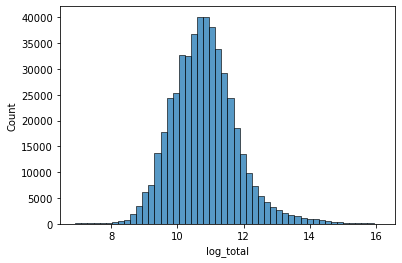

In [12]:
sns.histplot(data= df3[df3['tipo'] == 'Movil'], x = 'log_total',
             bins=50)

<AxesSubplot:xlabel='log_total', ylabel='Count'>

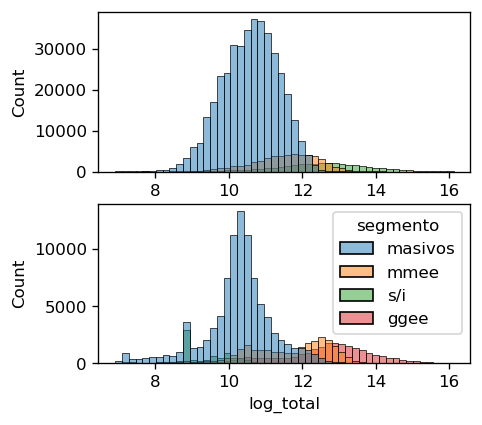

In [11]:
plt.figure(figsize=(4, 6), dpi=120)
ax1 = plt.subplot(311)
sns.histplot(data= df3[df3['tipo'] == 'Movil'], x = 'log_total',
             bins=50, hue = 'segmento', legend=False)

ax2 = plt.subplot(312, sharex=ax1)
sns.histplot(data= df3[df3['tipo'] == 'Fijo'], x = 'log_total',
             bins=50, hue = 'segmento')

In [12]:
rank = ['s/i', 'masivos', 'mmee', 'ggee']

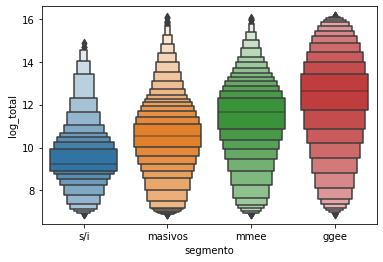

In [13]:
sns.boxenplot(x="segmento", y="log_total", order=rank,
              scale="linear", data=df3)

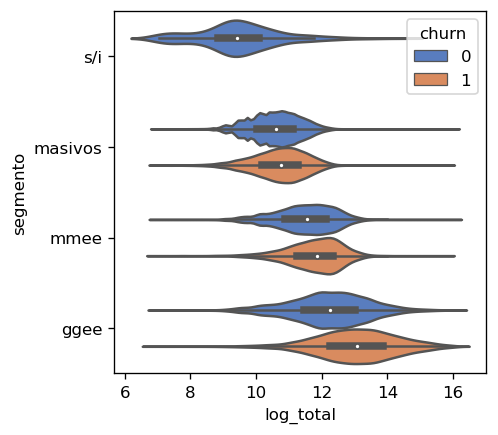

In [14]:
plt.figure(figsize=(4, 4), dpi=120)
sns.violinplot(y="segmento", x="log_total", hue='churn', order=rank,
                    data=df3[df3['tipo'] == 'Movil'], palette="muted")

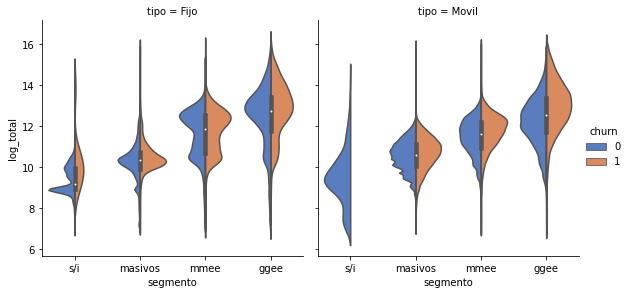

In [15]:
#plt.figure(figsize=(2, 4), dpi=120)
sns.catplot(x="segmento", y="log_total", hue='churn',
            col = 'tipo',  order=rank, kind="violin", split=True,
            data=df3, palette="muted", height=4)

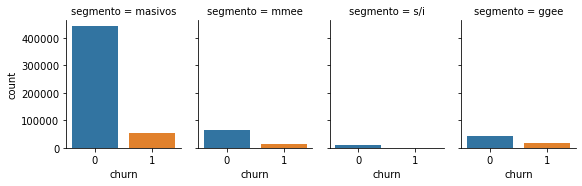

In [16]:
sns.catplot(x="churn", col="segmento", col_wrap=4,
            data = df3,
            kind="count",
            height=2.5, aspect=.8)

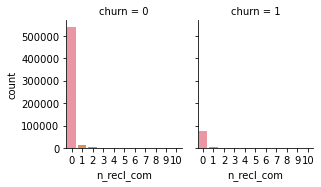

In [18]:
sns.catplot(x="n_recl_com", col="churn", col_wrap=4,
            data = df3,
            kind="count",
            height=2.5, aspect=.8)

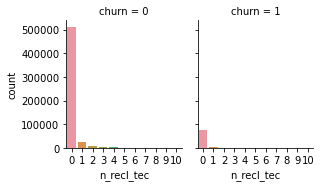

In [19]:
sns.catplot(x="n_recl_tec", col="churn", col_wrap=4,
            data = df3,
            kind="count",
            height=2.5, aspect=.8)

## Dividimos dataset en train y test y aplicamos RUS

In [12]:
y = df3['churn']

x = df3.drop(['churn', 'n_churn', 'total',
              'encriptado', 'periodo', 'nota_sem'], axis=1)

x = pd.get_dummies(x, columns = ['segmento'])
x = pd.get_dummies(x, columns = ['tipo'])

x= StandardScaler().fit_transform(x)

In [13]:
rus = RandomUnderSampler(random_state=0)
#rus = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(x, y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

# Probando AutoML

In [ ]:
!pip install h2o
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# Identify predictors and response
x = X_train.columns
y = "response"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].astype(factor)
test[y] = test[y].astype(factor)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
df3.v2 = df3.drop(['n_churn', 'total',
              'encriptado', 'periodo', 'nota_sem'], axis=1)
df3.v2 = pd.get_dummies(df3.v2, columns = ['segmento'])
df3.v2 = pd.get_dummies(df3.v2, columns = ['tipo'])

train, test = train_test_split(df3.v2, test_size=0.2)

# Identify predictors and response
x = list(train.columns)
y = "churn"
x.remove(y)

# For binary classification, response should be a factor
train["churn"] = train["churn"].astype('category')
test["churn"] = test["churn"].astype('category')

train=h2o.H2OFrame(train)


# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

## SVM 

In [35]:
svm = LinearSVC(random_state=0, tol=0.001, max_iter=20000)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.71      0.64     16266
           1       0.63      0.49      0.55     16453

    accuracy                           0.60     32719
   macro avg       0.60      0.60      0.59     32719
weighted avg       0.60      0.60      0.59     32719



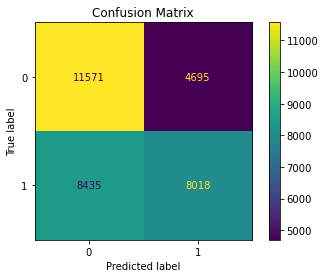

In [24]:
plot_confusion_matrix(svm, X_test, y_test)
plt.title('Confusion Matrix')
plt.show() 

In [ ]:
# # defining parameter range
# param_grid = {#'C': [0.1, 10, 100, 1000], 
#               #'gamma': [1, 0.01, 0.0001],
#               'kernel': ['rbf','linear', 'poly', 'sigmoid']} 

# grid_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........................kernel=rbf;, score=0.606 total time=45.9min
[CV 2/5] END ........................kernel=rbf;, score=0.603 total time=36.8min
[CV 3/5] END ........................kernel=rbf;, score=0.606 total time=48.6min
[CV 4/5] END ........................kernel=rbf;, score=0.607 total time=44.9min
[CV 5/5] END ........................kernel=rbf;, score=0.608 total time=50.5min
[CV 1/5] END .....................kernel=linear;, score=0.592 total time=28.0min
[CV 2/5] END .....................kernel=linear;, score=0.594 total time=29.9min
[CV 3/5] END .....................kernel=linear;, score=0.592 total time=27.7min
[CV 4/5] END .....................kernel=linear;, score=0.586 total time=30.6min
[CV 5/5] END .....................kernel=linear;, score=0.595 total time=27.2min


In [ ]:
# defining parameter range
param_grid = {#'C': [0.1, 10, 100, 1000], 
              #'gamma': [1, 0.01, 0.0001],
              'kernel': [ 'poly', 'sigmoid']} 

grid_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
#fitting the model for grid search
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ......................kernel=poly;, score=0.605 total time=121.0min
[CV 2/5] END ......................kernel=poly;, score=0.602 total time=128.1min
[CV 3/5] END ......................kernel=poly;, score=0.602 total time=119.5min
[CV 4/5] END ......................kernel=poly;, score=0.605 total time=122.3min


In [ ]:
grid_svm.best_params_

## Logit

In [62]:
logit = LogisticRegression(random_state=0, max_iter=500).fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64     16266
           1       0.63      0.50      0.55     16453

    accuracy                           0.60     32719
   macro avg       0.60      0.60      0.60     32719
weighted avg       0.60      0.60      0.60     32719



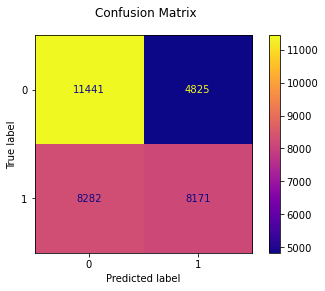

In [63]:
disp = plot_confusion_matrix(logit, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

In [58]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000],
             'tol': [0.0000001,0.00000001,0.000000001, 0.0000000000001],
             'max_iter':[100,500,1000,5000,10000]} 

grid_logit = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid_logit.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.595 total time=   0.0s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.605 total time=   0.0s
[CV 3/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.600 total time=   0.0s
[CV 4/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.603 total time=   0.0s
[CV 5/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.600 total time=   0.0s
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.595 total time=   0.0s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.605 total time=   0.0s
[CV 3/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 4/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.603 total time=   0.0s
[CV 5/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-09;, score=0.595 total time=   0.1s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-0

[CV 2/5] END ......C=1, max_iter=100, tol=1e-07;, score=0.605 total time=   0.0s
[CV 3/5] END ......C=1, max_iter=100, tol=1e-07;, score=0.600 total time=   0.0s
[CV 4/5] END ......C=1, max_iter=100, tol=1e-07;, score=0.603 total time=   0.1s
[CV 5/5] END ......C=1, max_iter=100, tol=1e-07;, score=0.600 total time=   0.0s
[CV 1/5] END ......C=1, max_iter=100, tol=1e-08;, score=0.595 total time=   0.0s
[CV 2/5] END ......C=1, max_iter=100, tol=1e-08;, score=0.605 total time=   0.0s
[CV 3/5] END ......C=1, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 4/5] END ......C=1, max_iter=100, tol=1e-08;, score=0.603 total time=   0.0s
[CV 5/5] END ......C=1, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 1/5] END ......C=1, max_iter=100, tol=1e-09;, score=0.595 total time=   0.0s
[CV 2/5] END ......C=1, max_iter=100, tol=1e-09;, score=0.605 total time=   0.0s
[CV 3/5] END ......C=1, max_iter=100, tol=1e-09;, score=0.600 total time=   0.0s
[CV 4/5] END ......C=1, max_

[CV 4/5] END .....C=10, max_iter=100, tol=1e-07;, score=0.603 total time=   0.0s
[CV 5/5] END .....C=10, max_iter=100, tol=1e-07;, score=0.600 total time=   0.0s
[CV 1/5] END .....C=10, max_iter=100, tol=1e-08;, score=0.595 total time=   0.1s
[CV 2/5] END .....C=10, max_iter=100, tol=1e-08;, score=0.605 total time=   0.0s
[CV 3/5] END .....C=10, max_iter=100, tol=1e-08;, score=0.600 total time=   0.1s
[CV 4/5] END .....C=10, max_iter=100, tol=1e-08;, score=0.603 total time=   0.1s
[CV 5/5] END .....C=10, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 1/5] END .....C=10, max_iter=100, tol=1e-09;, score=0.595 total time=   0.0s
[CV 2/5] END .....C=10, max_iter=100, tol=1e-09;, score=0.605 total time=   0.0s
[CV 3/5] END .....C=10, max_iter=100, tol=1e-09;, score=0.600 total time=   0.0s
[CV 4/5] END .....C=10, max_iter=100, tol=1e-09;, score=0.603 total time=   0.0s
[CV 5/5] END .....C=10, max_iter=100, tol=1e-09;, score=0.600 total time=   0.0s
[CV 1/5] END .....C=10, max_

[CV 2/5] END ....C=100, max_iter=100, tol=1e-08;, score=0.605 total time=   0.1s
[CV 3/5] END ....C=100, max_iter=100, tol=1e-08;, score=0.600 total time=   0.1s
[CV 4/5] END ....C=100, max_iter=100, tol=1e-08;, score=0.603 total time=   0.1s
[CV 5/5] END ....C=100, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 1/5] END ....C=100, max_iter=100, tol=1e-09;, score=0.595 total time=   0.0s
[CV 2/5] END ....C=100, max_iter=100, tol=1e-09;, score=0.605 total time=   0.1s
[CV 3/5] END ....C=100, max_iter=100, tol=1e-09;, score=0.600 total time=   0.1s
[CV 4/5] END ....C=100, max_iter=100, tol=1e-09;, score=0.603 total time=   0.1s
[CV 5/5] END ....C=100, max_iter=100, tol=1e-09;, score=0.600 total time=   0.0s
[CV 1/5] END ....C=100, max_iter=100, tol=1e-13;, score=0.595 total time=   0.1s
[CV 2/5] END ....C=100, max_iter=100, tol=1e-13;, score=0.605 total time=   0.0s
[CV 3/5] END ....C=100, max_iter=100, tol=1e-13;, score=0.600 total time=   0.0s
[CV 4/5] END ....C=100, max_

[CV 5/5] END ...C=1000, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 1/5] END ...C=1000, max_iter=100, tol=1e-09;, score=0.595 total time=   0.0s
[CV 2/5] END ...C=1000, max_iter=100, tol=1e-09;, score=0.605 total time=   0.0s
[CV 3/5] END ...C=1000, max_iter=100, tol=1e-09;, score=0.600 total time=   0.0s
[CV 4/5] END ...C=1000, max_iter=100, tol=1e-09;, score=0.603 total time=   0.0s
[CV 5/5] END ...C=1000, max_iter=100, tol=1e-09;, score=0.600 total time=   0.0s
[CV 1/5] END ...C=1000, max_iter=100, tol=1e-13;, score=0.595 total time=   0.0s
[CV 2/5] END ...C=1000, max_iter=100, tol=1e-13;, score=0.605 total time=   0.0s
[CV 3/5] END ...C=1000, max_iter=100, tol=1e-13;, score=0.600 total time=   0.0s
[CV 4/5] END ...C=1000, max_iter=100, tol=1e-13;, score=0.603 total time=   0.0s
[CV 5/5] END ...C=1000, max_iter=100, tol=1e-13;, score=0.600 total time=   0.0s
[CV 1/5] END ...C=1000, max_iter=500, tol=1e-07;, score=0.595 total time=   0.0s
[CV 2/5] END ...C=1000, max_

[CV 3/5] END ..C=10000, max_iter=100, tol=1e-09;, score=0.600 total time=   0.0s
[CV 4/5] END ..C=10000, max_iter=100, tol=1e-09;, score=0.603 total time=   0.0s
[CV 5/5] END ..C=10000, max_iter=100, tol=1e-09;, score=0.600 total time=   0.0s
[CV 1/5] END ..C=10000, max_iter=100, tol=1e-13;, score=0.595 total time=   0.0s
[CV 2/5] END ..C=10000, max_iter=100, tol=1e-13;, score=0.605 total time=   0.0s
[CV 3/5] END ..C=10000, max_iter=100, tol=1e-13;, score=0.600 total time=   0.0s
[CV 4/5] END ..C=10000, max_iter=100, tol=1e-13;, score=0.603 total time=   0.0s
[CV 5/5] END ..C=10000, max_iter=100, tol=1e-13;, score=0.600 total time=   0.0s
[CV 1/5] END ..C=10000, max_iter=500, tol=1e-07;, score=0.595 total time=   0.0s
[CV 2/5] END ..C=10000, max_iter=500, tol=1e-07;, score=0.605 total time=   0.0s
[CV 3/5] END ..C=10000, max_iter=500, tol=1e-07;, score=0.600 total time=   0.0s
[CV 4/5] END ..C=10000, max_iter=500, tol=1e-07;, score=0.603 total time=   0.0s
[CV 5/5] END ..C=10000, max_

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'max_iter': [100, 500, 1000, 5000, 10000],
                         'tol': [1e-07, 1e-08, 1e-09, 1e-13]},
             verbose=3)

In [59]:
grid_logit.best_params_

{'C': 10, 'max_iter': 100, 'tol': 1e-07}

### Ahora obtenemos el logit óptimo:

In [60]:
logit = LogisticRegression(random_state=0, max_iter=100,tol=1e-07,C=10).fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64     16266
           1       0.63      0.50      0.55     16453

    accuracy                           0.60     32719
   macro avg       0.60      0.60      0.60     32719
weighted avg       0.60      0.60      0.60     32719



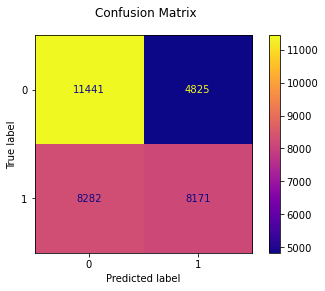

In [61]:
disp = plot_confusion_matrix(logit, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

## Random Forest

In [21]:
rf = RandomForestClassifier(
            n_estimators = 10, #El número de arboles en el bosque
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.62      0.60     16266
           1       0.60      0.57      0.58     16453

    accuracy                           0.59     32719
   macro avg       0.59      0.59      0.59     32719
weighted avg       0.59      0.59      0.59     32719



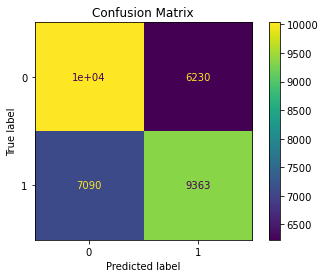

In [57]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

In [42]:
?RandomForestClassifier


In [43]:
# defining parameter range
param_grid = {'n_estimators': range(1, 16),
             'criterion': ['entropy','gini']} 

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .criterion=entropy, n_estimators=1;, score=0.592 total time=   0.3s
[CV 2/5] END .criterion=entropy, n_estimators=1;, score=0.593 total time=   0.3s
[CV 3/5] END .criterion=entropy, n_estimators=1;, score=0.586 total time=   0.3s
[CV 4/5] END .criterion=entropy, n_estimators=1;, score=0.587 total time=   0.3s
[CV 5/5] END .criterion=entropy, n_estimators=1;, score=0.587 total time=   0.4s
[CV 1/5] END .criterion=entropy, n_estimators=2;, score=0.581 total time=   0.8s
[CV 2/5] END .criterion=entropy, n_estimators=2;, score=0.586 total time=   0.9s
[CV 3/5] END .criterion=entropy, n_estimators=2;, score=0.581 total time=   0.9s
[CV 4/5] END .criterion=entropy, n_estimators=2;, score=0.584 total time=   0.8s
[CV 5/5] END .criterion=entropy, n_estimators=2;, score=0.581 total time=   0.7s
[CV 1/5] END .criterion=entropy, n_estimators=3;, score=0.592 total time=   1.3s
[CV 2/5] END .criterion=entropy, n_estimators=3

[CV 2/5] END ....criterion=gini, n_estimators=6;, score=0.591 total time=   1.5s
[CV 3/5] END ....criterion=gini, n_estimators=6;, score=0.588 total time=   1.5s
[CV 4/5] END ....criterion=gini, n_estimators=6;, score=0.590 total time=   1.4s
[CV 5/5] END ....criterion=gini, n_estimators=6;, score=0.588 total time=   1.4s
[CV 1/5] END ....criterion=gini, n_estimators=7;, score=0.592 total time=   1.7s
[CV 2/5] END ....criterion=gini, n_estimators=7;, score=0.594 total time=   1.6s
[CV 3/5] END ....criterion=gini, n_estimators=7;, score=0.593 total time=   1.6s
[CV 4/5] END ....criterion=gini, n_estimators=7;, score=0.596 total time=   1.6s
[CV 5/5] END ....criterion=gini, n_estimators=7;, score=0.595 total time=   1.6s
[CV 1/5] END ....criterion=gini, n_estimators=8;, score=0.592 total time=   1.9s
[CV 2/5] END ....criterion=gini, n_estimators=8;, score=0.591 total time=   2.1s
[CV 3/5] END ....criterion=gini, n_estimators=8;, score=0.589 total time=   2.1s
[CV 4/5] END ....criterion=g

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'n_estimators': range(1, 16)},
             verbose=3)

In [ ]:
grid_rf.best_params_

Text(0, 0.5, 'Testing Accuracy')

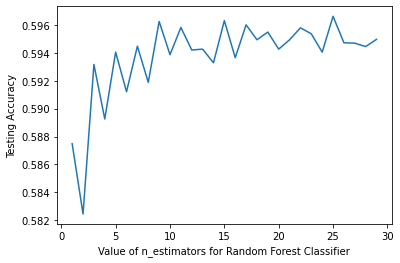

In [14]:
from sklearn.metrics import accuracy_score


scores =[]
for k in range(1, 30):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1, 30), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')


### Ahora obtenemos el árbol óptimo:

In [33]:
rf = RandomForestClassifier(
            n_estimators = 7,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123,
            criterion ='gini'
         )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59     16266
           1       0.60      0.59      0.60     16453

    accuracy                           0.59     32719
   macro avg       0.59      0.59      0.59     32719
weighted avg       0.59      0.59      0.59     32719



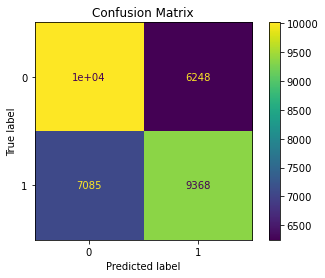

In [22]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()